In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from scipy import stats
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.datasets import load_breast_cancer
import warnings
warnings.filterwarnings('ignore')

In [2]:
#Load the dataset
x_breast,y_breast=load_breast_cancer(return_X_y=True)
x=pd.DataFrame(x_breast)
y=pd.Series(y_breast).map({0:1,1:0})

In [4]:
x.head()

,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [3]:
#percentage of the target columns
y.value_counts()/len(y)

0    0.627417
1    0.372583
dtype: float64

In [5]:
#split the dataset into train and the test set
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.3,random_state=0)
print(x_train.shape)
print(x_test.shape)

(398, 30)
(171, 30)


In [6]:
stats.randint.rvs(1,5)

1

In [11]:
stats.uniform.rvs(0,1)

0.1629552331906433

# Random Search

In [8]:
#Set up the model
gbm=GradientBoostingClassifier(random_state=0)
#determine the hyperparameter space
param_grid=dict(
n_estimators=stats.randint(10,120),
min_samples_split=stats.uniform(0,1),
max_depth=stats.randint(1,5),
loss=('deviance','exponential'))

In [12]:
#set up the search
search=RandomizedSearchCV(gbm,param_distributions=param_grid,scoring='roc_auc',cv=5,n_iter=60,random_state=10,n_jobs=4,refit=True)
#find the best hyperparameters
search.fit(x_train,y_train)

RandomizedSearchCV(cv=5, estimator=GradientBoostingClassifier(random_state=0),
                   n_iter=60, n_jobs=4,
                   param_distributions={'loss': ('deviance', 'exponential'),
                                        'max_depth': <scipy.stats._distn_infrastructure.rv_frozen object at 0x0000027B3D3218D0>,
                                        'min_samples_split': <scipy.stats._distn_infrastructure.rv_frozen object at 0x0000027B3AE6ABF0>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_frozen object at 0x0000027B3B439C00>},
                   random_state=10, scoring='roc_auc')

In [13]:
print(search.best_params_)

{'loss': 'exponential', 'max_depth': 3, 'min_samples_split': 0.5345579488018151, 'n_estimators': 99}


In [15]:
results=pd.DataFrame(search.cv_results_)
results.sort_values(by='mean_test_score',ascending=False,inplace=True)
results.reset_index(drop=True,inplace=True)
results[['param_max_depth','param_min_samples_split','param_n_estimators','mean_test_score','std_test_score']].head()

,param_max_depth,param_min_samples_split,param_n_estimators,mean_test_score,std_test_score
0,3,0.534558,99,0.993171,0.006967
1,2,0.043097,115,0.992885,0.005906
2,2,0.020752,74,0.992763,0.006273
3,4,0.565507,92,0.992689,0.006204
4,2,0.30546,92,0.992567,0.007091


Text(0.5, 0, 'Hyperparameter combinations')

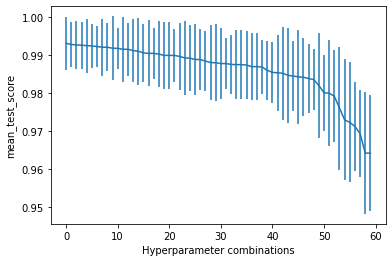

In [16]:
#Plot the model performance and the error
results['mean_test_score'].plot(yerr=[results['std_test_score'],results['std_test_score']])
plt.ylabel('mean_test_score')
plt.xlabel('Hyperparameter combinations')

In [17]:
#Lets do the prediction
x_train_pred=search.predict_proba(x_train)[:,1]
x_test_pred=search.predict_proba(x_test)[:,1]
print("Training roc_auc score:",roc_auc_score(y_train,x_train_pred))
print("Testing roc_auc score:",roc_auc_score(y_test,x_test_pred))

Training roc_auc score: 1.0
Testing roc_auc score: 0.9988242210464433


In [18]:
#Lets make the function to evaluate the model performance based on
#single hyperparameter
def summarize_by_param(hparam):
    tmp=pd.concat([
        results.groupby(hparam)['mean_test_score'].mean(),
        results.groupby(hparam)['mean_test_score'].std(),
    ],axis=1)
    tmp.columns=['mean_test_score','std_test_score']
    return tmp

In [19]:
#performannce change for the n_estimators
tmp=summarize_by_param('param_n_estimators')
tmp.head()

,mean_test_score,std_test_score
param_n_estimators,,
10,0.964246,0.000003
14,0.969349,NaN
16,0.979216,NaN
17,0.984554,NaN
18,0.976262,0.005518


Text(0, 0.5, 'roc_auc')

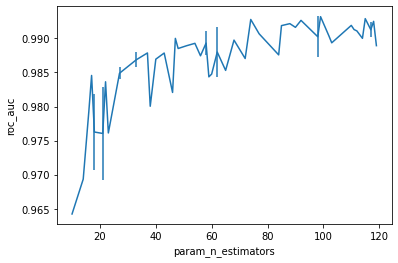

In [20]:
tmp['mean_test_score'].plot(yerr=[tmp['std_test_score'],tmp['std_test_score']],subplots=True)
plt.ylabel('roc_auc')

The optimal hyperparameter seems to be somewhere between 60 and 100

Text(0, 0.5, 'roc_auc')

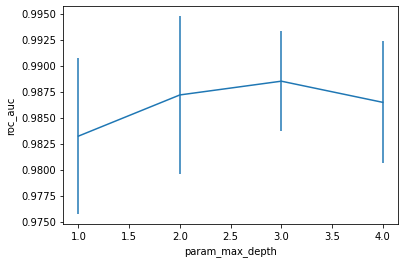

In [22]:
tmp=summarize_by_param('param_max_depth')
tmp['mean_test_score'].plot(yerr=[tmp['std_test_score'],tmp['std_test_score']],subplots=True)
plt.ylabel('roc_auc')

The optimal hyperparameter seems to be between 2 and 3

Text(0, 0.5, 'roc-auc')

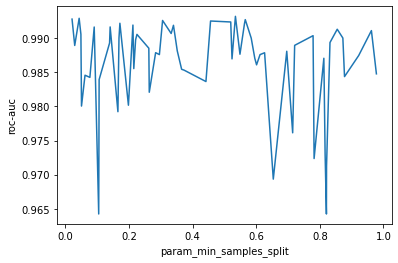

In [23]:
tmp=summarize_by_param('param_min_samples_split')
tmp['mean_test_score'].plot(yerr=[tmp['std_test_score'],tmp['std_test_score']],subplots=True)
plt.ylabel('roc-auc')

The parameter doesnot seems to improve much

(0.97, 1.0)

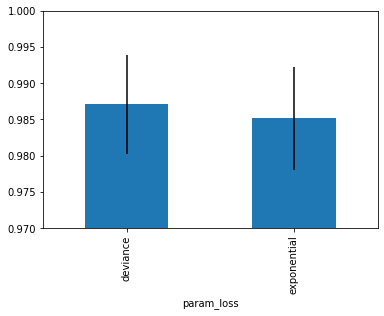

In [24]:
tmp=summarize_by_param('param_loss')
tmp['mean_test_score'].plot.bar(yerr=[tmp['std_test_score'],tmp['std_test_score']])
plt.ylim(0.97,1)